# Lecture 10 - Basis Functions & Bayesian Interpretation

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
def NoisySinusoidalData(N, a, b, gVar):
    x = np.linspace(a,b,N)
    noise = npr.normal(0,gVar,N)
    t = np.sin(2*np.pi*x) + noise
    return x, t

Ntrain, Ntest = 100, 30
a, b = [0,1] 
sigma_train, sigma_test = 0.3, 0.5
x_train, t_train = NoisySinusoidalData(Ntrain, a, b, sigma_train)    # training data and labels
x_true, t_true = NoisySinusoidalData(Ntrain, a, b, 0)             #true sine function
x_test, t_test = NoisySinusoidalData(Ntest, a, b, sigma_test) # test data and labels

# Basis Functions

So far, we have assumed that we have form a **feature matrix** $\mathbf{X}$ of dimensions $N \times M$, where $N$ is the number of samples and $M$ the number of coefficients.

* In Polynomial Regression, we constructed this matrix with a polynomial representation of each data sample:

$$\phi(x_i) = [x_i^0, x_i^1, \cdots, x_i^p]^T$$

In practice, we can use other types of features. But, from a software implementation point-of-view, regardless of the features used, we always want to have them in a tidy feature matrix $\mathbf{X}$:

$$\mathbf{X} =\left[\begin{array}{c} \phi(x_1)^T \\ \phi(x_2)^T \\ \vdots \\ \phi(x_N)^T \end{array}\right]  = \left[\begin{array}{ccccc}
1 & x_{1} & x_{1}^{2} & \cdots & x_{1}^{p}\\
1 & x_{2} & x_{2}^{2} & \cdots & x_{2}^{p}\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_{N} & x_{N}^{2} & \cdots & x_{N}^{p}
\end{array}\right] \in \mathbb{R}^{N\times M}$$

where $M=p+1$.

* In mathematics, the polynomial feature representation that we have used is called a **polynomial basis function** and is a basis of a polynomial ring.

* We can also implement the **Linear Regression** model using other feature representations, also called **basis functions** $\phi(\mathbf{x})$. 

    * **Assumption:** we are assuming that true *unknown* function $f(x)$ can be modeled by at least one of the functions $\phi(\mathbf{x})$ that can be represented by a linear combination of the basis functions, i.e., by one function in the function class under consideration.
    
    * If we include **too few** basis functions or unsuitable basis functions, we might not be able to model the true dependency. Similarly to polynomial features, the more we added, the better fit we have to out training data.
    
    * If we include **too many** basis functions, we need many data points to fit all the unknown parameters.
        * There are special function spaces such as the Reproducing Kernel Hilbert Space or RKHS, where we can have an *infinite* number of basis functions (called kernels) and still have good generalization.
    
    * What we control? Which basis functions to use, how many to use, and any other parameters they have.

Some examples include:

1. **Radial Basis Functions (RBF)**

Another popular class of basis functions are radial basis functions (RBF). Typical representatives are Gaussian basis functions:

$$\phi_j(x) = \exp\left\{-\frac{(x-\mu_j)^2)}{2s_j^2}\right\}$$

In [3]:
def RBF(x,m,s):
    return np.exp(- ((x-m)**2)/(2*s**2))

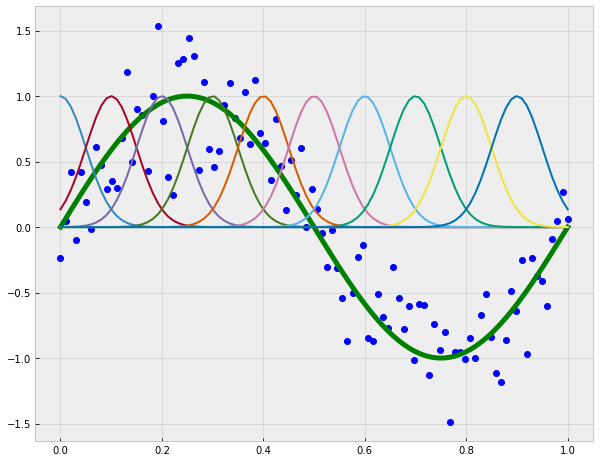

In [4]:
M = 10
m = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
s = [0.05]*10

fig = plt.figure(figsize=(10,8))
plt.plot(x_train,t_train,'bo', label='Training Data')
plt.plot(x_true, t_true,'g',linewidth=5, label = 'True Function')
for i in range(M):
    plt.plot(x_train, RBF(x_train,m[i],s[i]));

Given these basis functions, we need to:
1. compute the weight value that each one has in representing the underlying function $f(x)$ - these are the coefficient $\mathbf{w}$
2. estimate the parameters of each basis function, in particular, the mean $\mu$ and standard deviation $\sigma$ for each Gaussian basis function

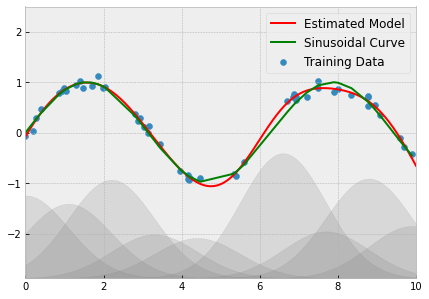

In [5]:
# Example from textbook "Python Data Science Handbook"
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Gaussian-Basis-Functions

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly-spaced Gaussian Features for 1D input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50) # Noisy sinusoidal curve
xfit = np.linspace(0, 10, 1000)

gauss_model = make_pipeline(GaussianFeatures(10, 1.0),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

gf = gauss_model.named_steps['gaussianfeatures']
lm = gauss_model.named_steps['linearregression']

fig, ax = plt.subplots(figsize=(7,5))

for i in range(10):
    selector = np.zeros(10)
    selector[i] = 1
    Xfit = gf.transform(xfit[:, None]) * selector
    yfit = lm.predict(Xfit)
    ax.fill_between(xfit, yfit.min(), yfit, color='gray', alpha=0.2)

ax.scatter(x, y,label='Training Data')
ax.plot(xfit, gauss_model.predict(xfit[:, np.newaxis]),'r',label='Estimated Model')
ax.plot(np.sort(x), np.sin(np.sort(x)), 'g',label='Sinusoidal Curve')
ax.set_xlim(0, 10)
ax.set_ylim(yfit.min(),2.5)
plt.legend(fontsize=12);

We will study this into more detail when introducing **Gaussian Mixture Models (GMMs)**, but we are not quite ready yet...

Other basis functions include:

2. **Fourier Basis functions**

3. **Wavelet Basis functions**

4. and many others

# Bayesian Interpretation - The Evidence Approximation

We can look at the **Regularized Least Squares** in the "Objective Function world", where we simply add a term to our objective in order to prevent overfitting and, consequently, allow the model to generalize to unseen and unkown data.

Another way to look at Regularized Least Squares is from a Bayesian point-of-view. To see this, let's look at our objective function:

$$J(\mathbf{w})= \frac{1}{2N}\sum_{n=1}^N \left(t_n - y_n\right)^2 + \frac{\lambda}{2} \sum_{j} w_j^2$$

Now, if we optimize for a solution for $\mathbf{w}$, we have

\begin{align}
& \arg_{\mathbf{w}}\min \left(J(\mathbf{w})\right) \\
= & \arg_{\mathbf{w}}\max \left(- J(\mathbf{w})\right) \\
= & \arg_{\mathbf{w}}\max \left(\exp\left(- J(\mathbf{w})\right)\right) \text{, }\exp(\bullet)\text{ is a monotonic function}  
\end{align}

Substituting,

\begin{align}
& \arg_{\mathbf{w}}\max \left(\exp\left(-\frac{1}{2N}\sum_{n=1}^N \left(t_n - y_n\right)^2 - \frac{\lambda}{2} \sum_{j} w_j^2)\right)\right) \\
\propto & \arg_{\mathbf{w}}\max \left(\exp\left(-\frac{1}{2}\sum_{n=1}^N \left(t_n - y_n\right)^2 - \frac{\lambda}{2} \sum_{j} w_j^2)\right)\right) \\
= & \arg_{\mathbf{w}}\max \left(\exp\left(-\frac{1}{2}\sum_{n=1}^N \left(t_n - y_n\right)^2\right) \exp\left(- \frac{\lambda}{2} \sum_{j} w_j^2)\right)\right) \\
=& \arg_{\mathbf{w}}\max \left(\prod_{n=1}^N \exp\left(-\frac{1}{2}\left(t_n - y_n\right)^2\right) \prod_{j} \exp \left(-\frac{\lambda}{2} w_j^2\right) \right)  \\
\approx & \arg_{\mathbf{w}}\max G\left(\mathbf{t}|\mathbf{y}, 1\right) G\left(\mathbf{w}|0, 1/\lambda\right)\text{, assuming data }\{(x_i,t_i)\}_{i=1}^N\text{ is i.i.d.} \\
=& \arg_{\mathbf{w}}\max P(\mathbf{t}|\mathbf{w}) P(\mathbf{w}), \mathbf{y} \text{ is a function of }\mathbf{w}\\
=& \arg_{\mathbf{w}}\max P(\mathbf{w}|\mathbf{t}) P(\mathbf{t}), \text{ using Bayes' Theorem} \\
\propto & \arg_{\mathbf{w}}\max P(\mathbf{w}|\mathbf{t}), \text{because } P(\mathbf{t})\text{ is constant for some fixed training set}  
\end{align}

where $P(\mathbf{t}|\mathbf{w})$ is the **data likelihood** of the target label vector $\mathbf{t}$ given some coefficients $\mathbf{w}$, $P(\mathbf{w})$ is the **prior** on the parameters, and $P(\mathbf{w}|\mathbf{t})$ is the **posterior probability**.

In Machine Learning, this result is known as the **evidence approximation**.

* In practice, this means that we now can rewrite the Regularized Least Squares problem as the product between the *data likelihood* and a *prior distribution* on the parameters. 

    * In particular, for Least Squares cost function and an L2- regularization term, both data likelihood and prior distributions are Gaussian-distributed.
    
* Now, we can select **any** distribution function to our data and control the regularization also using a probabilistic model!

**What is the shape of the prior distribution if we had considered the L1-norm or the Lasso regularizer?**

* Recall that, if $X$ is Laplacian distributed with parameters $\mu$ and $b$ ($b>0$), its probability density function (pdf) is defined as: 

$$f_X(x) = \frac{1}{2b}\exp\left\{-\frac{|x-\mu|}{b}\right\}$$

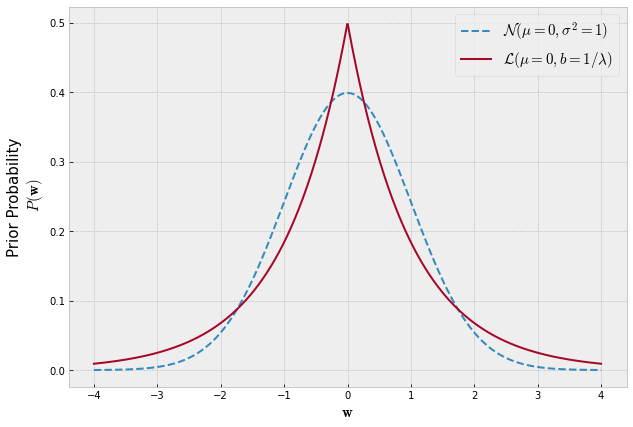

In [6]:
x = np.linspace(-4,4,1000)
Gaussian = np.exp(-x**2/2)/np.sqrt(2*np.pi) #Gaussian with zero-mean and unit-variance
Laplacian = np.exp(-np.abs(x))/(2) #Laplacian with zero-mean and lambda=1

plt.figure(figsize=(10,7))
plt.plot(x, Gaussian, '--', label='$\mathcal{N}(\mu=0,\sigma^2=1)$')
plt.plot(x, Laplacian, label='$\mathcal{L}(\mu=0,b=1/\lambda)$')
plt.legend(loc='best', fontsize=15)
plt.xlabel('$\mathbf{w}$', size=15)
plt.ylabel('Prior Probability\n $P(\mathbf{w})$', size=15);

# Maximum Likelihood Estimation (MLE) & Maximum A Posteriori (MAP)

Recall that our goal is to find the set of hyper-parameters that best fit our data. 

With the evidence approximation, rather than integrating over all possible values, we can use Bayesian inferencing to find the set of coefficients that maximize a distribution.

For the **Regularized Least Squares** objective function, we just showed that our optimization problem can be reduced to:

* Maximizing the **posterior** probability, that takes the shape of a Gaussian distribution, of unknown hyper-parameters.

For the **Least Squares without regularization** objective function, we just showed that our optimization problem can be reduced to:

* Maximizing the **data likelihood**, that takes the shape of a Gaussian distribution, with unknown hyper-parameters.

In our problem, the hypothesis are the *unknown* **hyper-parameters** $\mathbf{w}$.

* In Bayesian statistical inferencing, we are then trying to find the $\mathbf{w}$'s that maximizing the posterior probability.
* In classical statistical inferencing, on the other hand, we are only computing the probability of some hypothesis (the *null hypothesis*).

<h2 align="center"><span style="color:blue">Maximum Likelihood Estimation (MLE)</span></h2>
<center>(Frequentist approach)</center>

In **Maximum Likelihood Estimation** (also referred to as **MLE**) we want to *find the set of parameters* that **maximize** the data likelihood $P(\mathbf{x}|\mathbf{w})$. We want to find the *optimal* set of parameters under some assumed distribution such that the data is most likely.

<h2 align="center"><span style="color:orange">Maximum A Posteriori (MAP)</span></h2>
<center>(Bayesian approach)</center>

In **Maximum A Posteriori** (also referred as **MAP**) we want to *find the set of parameters* that **maximize** the posteriori probability $P(\mathbf{w}|\mathbf{x})$. We want to find the *optimal* set of parameters under some assumed distribution such that the parameters are most likely to have been drawn off of given some prior beliefs.

## Example

**Suppose you flip a coin 3 times and observe the event H-H-H. What is the probability that the next flip is also Heads (H)?**

1. From Classical probability, what is the probability of heads in the next flip?

    * $P(H) = \frac{\text{# observed Heads}}{\text{# flips}} = \frac{3}{3} = 1$

2. Bayesian Inference: What is the **hidden state** in this problem?

    * Hidden state: what type of coin was use in the experiment
    * Let's consider there could been two types of coins in play: 1 fair coin and 1 2-headed coin
    * So, by the Law of Total Probability:
    
    $$P(H) = P(H|\text{fair})P(\text{fair}) + P(\overline{H}|\text{2-headed})P(\text{2-headed})$$
    * Furthermore, we can test different hypothesis by checking which hypothesis has the largest posterior probability value, e.g. if $P(\text{fair}|E) > P(\text{2-headed}|E)$, then hypothesis "fair" is more likely and that is what we will use to make predictions.
    
3. Let $H_i$ be the event of observing Heads on flip $i$. Note that the events $H_i$ are **conditionally independent**, that is: $P(H_1\cap H_2|\text{fair}) = P(H_1|\text{fair})P(H_2|\text{fair})$. But they are **not** (necessarily) statistically independent.
    * This is often an assumption that we make about data samples, we say that the samples are **independent and identically distributed (i.i.d.)**.

Now, let's consider heads=1 and tails=0, so our sample space is $S=\{1,0\}$. Now, let the probability of heads is equal to some *unknown* value $\mu$, then:

\begin{align}
& P(x=1 | \mu) = \mu \\
& P(x=0|\mu) = 1-\mu
\end{align}

We can compute the data likelihood as:

$$P(x|\mu) = \mu^x(1-\mu)^{1-x} = \begin{cases}\mu & \text{if }x=1 \\ 1-\mu & \text{if } x=0 \end{cases}$$

* This is the **Bernoulli distribution**. The mean and variance of the Bernoulli distribution are: $E[x] = \mu$ and $E[\left(x- E[x]\right)^2] = \mu(1-\mu)$.

* So, for every outcome of the event $E$, we will model it using a Bernoulli distribution, and each outcome is pairwise **conditionally independent**. Therefore, we have the event $E$ contains i.i.d. outcomes.